## LIBRERIAS

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# from stastmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
# import ace_tools as tools

### CARGAR DATOS Y ANALISIS GENERAL

In [2]:
sell_in = pd.read_csv('sell-in.txt.gz', compression='gzip', sep='\t')
productos = pd.read_csv('tb_productos.txt', sep='\t')
prod_predecir = pd.read_csv('tb_prod_predecir.txt', sep='\t')  
stocks= pd.read_csv('tb_stocks.txt', sep='\t')

# Paso 1: Merge entre ventas y productos usando `product_id`
df_ventas_productos = pd.merge(sell_in, productos, on='product_id', how='left')

# Paso 2: Merge con el stock, usando `periodo` y `product_id`
df = pd.merge(df_ventas_productos, stocks, on=['periodo', 'product_id'], how='left')
# 3. Conversión de 'periodo' a datetime
df['periodo'] = pd.to_datetime(df['periodo'].astype(str) + '01', format='%Y%m%d')


In [29]:

# 2. Información general
print("Información de columnas y tipos:")
print(sell_in.info())
print(productos.info())
print(stocks.info())

print("\nEstadísticas descriptivas (numéricas):")
print(sell_in.describe())
print(productos.describe())
print(stocks.describe())

print("\nValores faltantes por columna:")
print(sell_in.isnull().sum())
print(productos.isnull().sum())
print(stocks.isnull().sum())

print(df.isnull().sum())

print("\n15 Valores del top")
print(sell_in.head(10))
print(productos.head(10))

Información de columnas y tipos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2945818 entries, 0 to 2945817
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   periodo                int64  
 1   customer_id            int64  
 2   product_id             int64  
 3   plan_precios_cuidados  int64  
 4   cust_request_qty       int64  
 5   cust_request_tn        float64
 6   tn                     float64
dtypes: float64(2), int64(5)
memory usage: 157.3 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1262 entries, 0 to 1261
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   cat1        1262 non-null   object
 1   cat2        1262 non-null   object
 2   cat3        1262 non-null   object
 3   brand       1262 non-null   object
 4   sku_size    1262 non-null   int64 
 5   product_id  1262 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 59.3+ 

In [22]:
# periodo min para sell_in
print(f"\nPeriodo mínimo para sell_in: {sell_in['periodo'].min()}")
# periodo max para sell_in
print(f"\nPeriodo maximo para sell_in: {sell_in['periodo'].max()}")

# periodo min para stocks
print(f"\nPeriodo mínimo para stocks: {stocks['periodo'].min()}")
# periodo max para sell_in
print(f"\nPeriodo maximo para stocks: {stocks['periodo'].max()}")




Periodo mínimo para sell_in: 201701

Periodo maximo para sell_in: 201912

Periodo mínimo para stocks: 201810

Periodo maximo para stocks: 201912


### TENDENCIAS Y DISTRIBUCIONES

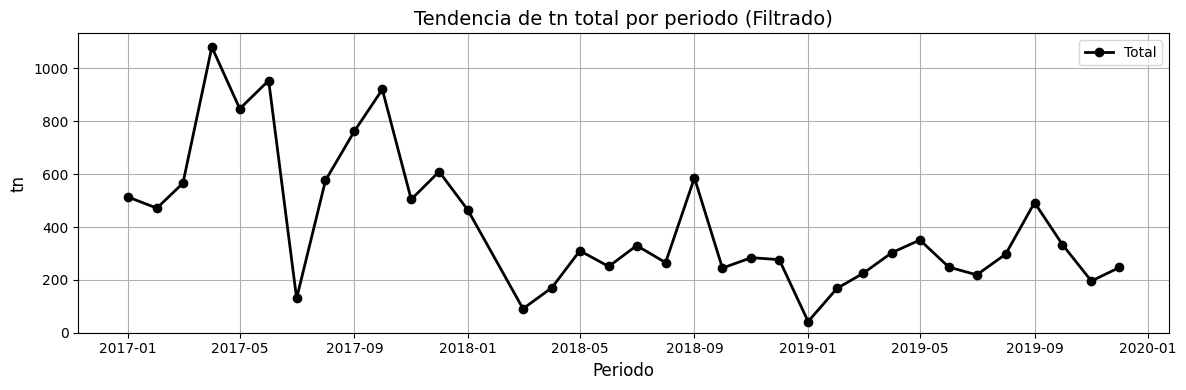

In [32]:
#  Parámetros de filtro
customers = ['10020']  # Lista de customer_id a incluir (puedes dejarla vacía para no filtrar)
products = ['']  # Lista de product_id a incluir (puedes dejarla vacía para no filtrar)

# Aplicar filtros al DataFrame
filtered_df = df.copy()
if customers:
    filtered_df = filtered_df[filtered_df['customer_id'].astype(str).isin(customers)]
# if products:
#     filtered_df = filtered_df[filtered_df['product_id'].astype(str).isin(products)]

# Calcular el total de tn por periodo
period_total_tn = filtered_df.groupby('periodo')['tn'].sum().reset_index()

# Crear el gráfico
plt.figure(figsize=(12, 4))

# Graficar la línea del total con marcadores
plt.plot(period_total_tn['periodo'], period_total_tn['tn'], label='Total', color='black', linewidth=2, marker='o')

# Configurar etiquetas y título
plt.title('Tendencia de tn total por periodo (Filtrado)', fontsize=14)
plt.ylabel('tn', fontsize=12)
plt.xlabel('Periodo', fontsize=12)
plt.ylim(bottom=0)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [34]:
print(period_total_tn)

      periodo          tn
0  2017-01-01   513.59911
1  2017-02-01   471.35001
2  2017-03-01   565.80789
3  2017-04-01  1080.95718
4  2017-05-01   847.58518
5  2017-06-01   954.25447
6  2017-07-01   129.87813
7  2017-08-01   576.40175
8  2017-09-01   762.58150
9  2017-10-01   920.50860
10 2017-11-01   504.50455
11 2017-12-01   609.67787
12 2018-01-01   463.06990
13 2018-03-01    90.77877
14 2018-04-01   170.44725
15 2018-05-01   310.20835
16 2018-06-01   250.66306
17 2018-07-01   329.92085
18 2018-08-01   265.28592
19 2018-09-01   586.08503
20 2018-10-01   244.69947
21 2018-11-01   283.93161
22 2018-12-01   276.61916
23 2019-01-01    42.41448
24 2019-02-01   167.95029
25 2019-03-01   224.56734
26 2019-04-01   303.23557
27 2019-05-01   350.77031
28 2019-06-01   248.33707
29 2019-07-01   218.93236
30 2019-08-01   297.18241
31 2019-09-01   492.49610
32 2019-10-01   333.30432
33 2019-11-01   195.58380
34 2019-12-01   246.84855


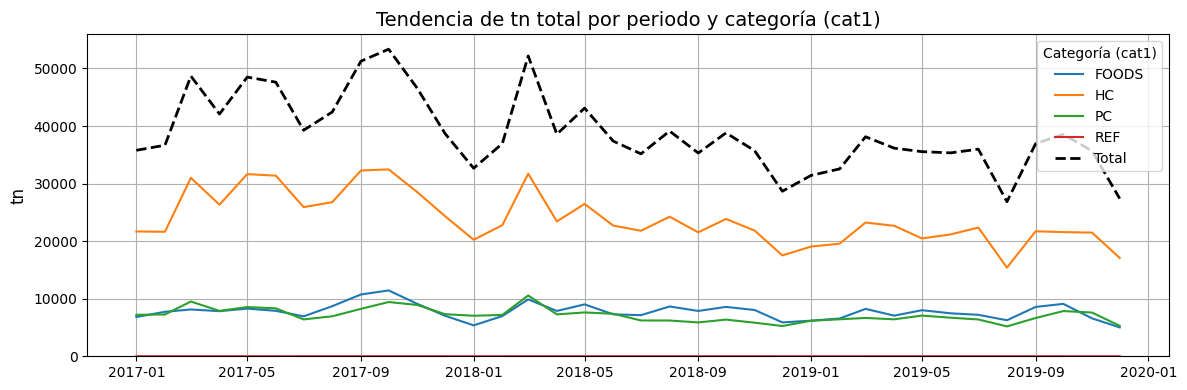

In [ ]:
# Agrupar por periodo y cat1, y calcular la suma de tn
period_cat1_tn = df.groupby(['periodo', 'cat1'])['tn'].sum().reset_index()

# Calcular el total de tn por periodo
period_total_tn = df.groupby('periodo')['tn'].sum().reset_index()


# Crear el gráfico
plt.figure(figsize=(12, 6))

# Graficar una línea para cada categoría en cat1
for cat in period_cat1_tn['cat1'].unique():
    data = period_cat1_tn[period_cat1_tn['cat1'] == cat]
    plt.plot(data['periodo'], data['tn'], label=cat)


# Graficar la línea del total
plt.plot(period_total_tn['periodo'], period_total_tn['tn'], label='Total', color='black', linewidth=2, linestyle='--')

# Configurar etiquetas y título
plt.title('Tendencia de tn total por periodo y categoría (cat1)', fontsize=14)
plt.ylabel('tn', fontsize=12)
plt.ylim(bottom=0)
plt.legend(title='Categoría (cat1)')
plt.grid(True)
plt.tight_layout()

# Mostrar el gráfico
plt.show()


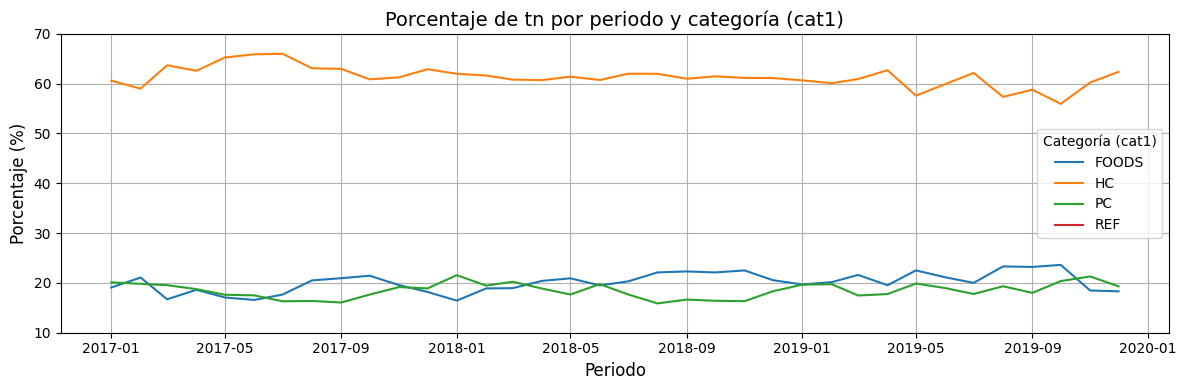

In [37]:
# Calcular el total de tn por periodo
period_total_tn = df.groupby('periodo')['tn'].sum().reset_index()

# Calcular el porcentaje de tn por periodo y cat1
period_cat1_tn = df.groupby(['periodo', 'cat1'])['tn'].sum().reset_index()
period_cat1_tn = period_cat1_tn.merge(period_total_tn, on='periodo', suffixes=('', '_total'))
period_cat1_tn['tn_pct'] = (period_cat1_tn['tn'] / period_cat1_tn['tn_total']) * 100

# Crear el gráfico
plt.figure(figsize=(12, 4))

# Graficar una línea para cada categoría en cat1
for cat in period_cat1_tn['cat1'].unique():
    data = period_cat1_tn[period_cat1_tn['cat1'] == cat]
    plt.plot(data['periodo'], data['tn_pct'], label=cat)

# Configurar etiquetas y título
plt.title('Porcentaje de tn por periodo y categoría (cat1)', fontsize=14)
plt.ylabel('Porcentaje (%)', fontsize=12)
plt.xlabel('Periodo', fontsize=12)
plt.ylim(10, 70)  # El porcentaje estará entre 0 y 100
plt.legend(title='Categoría (cat1)')
plt.grid(True)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

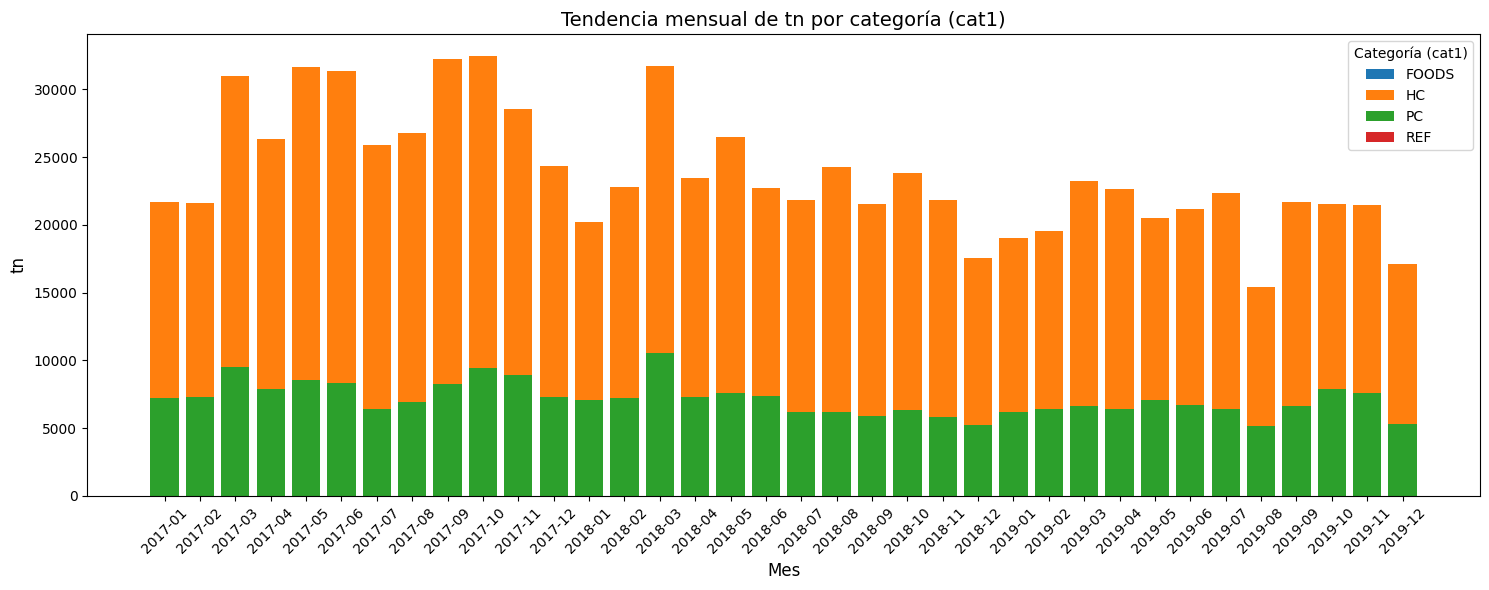

In [31]:

# Asegúrate de que la columna 'periodo' esté en formato datetime
df['periodo'] = pd.to_datetime(df['periodo'])

# Crear una nueva columna para el mes
df['mes'] = df['periodo'].dt.to_period('M')

# Agrupar por mes y cat1, y calcular la suma de tn
monthly_cat1_tn = df.groupby(['mes', 'cat1'])['tn'].sum().reset_index()

# Crear el gráfico de barras
plt.figure(figsize=(15, 6))

# Iterar sobre cada categoría en cat1 y graficar las barras
for cat in monthly_cat1_tn['cat1'].unique():
    data = monthly_cat1_tn[monthly_cat1_tn['cat1'] == cat]
    plt.bar(data['mes'].astype(str), data['tn'], label=cat)

# Configurar etiquetas y título
plt.title('Tendencia mensual de tn por categoría (cat1)', fontsize=14)
plt.xlabel('Mes', fontsize=12)
plt.ylabel('tn', fontsize=12)
plt.legend(title='Categoría (cat1)')
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

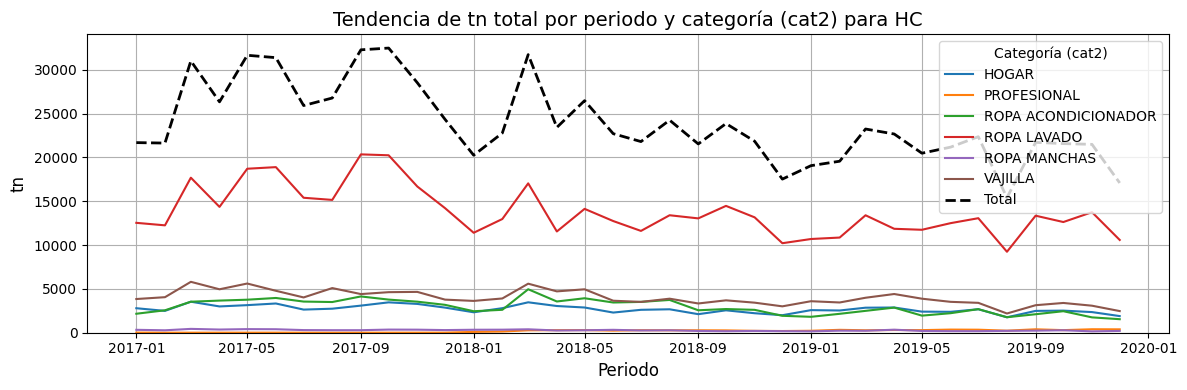

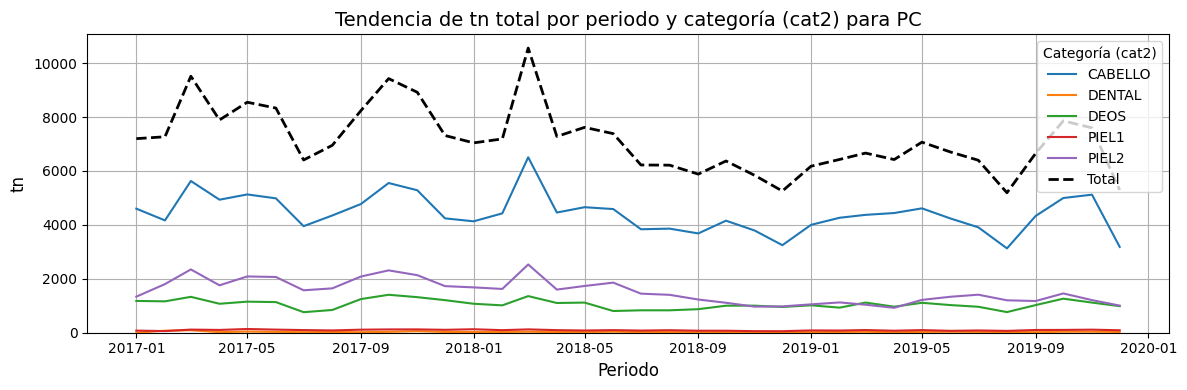

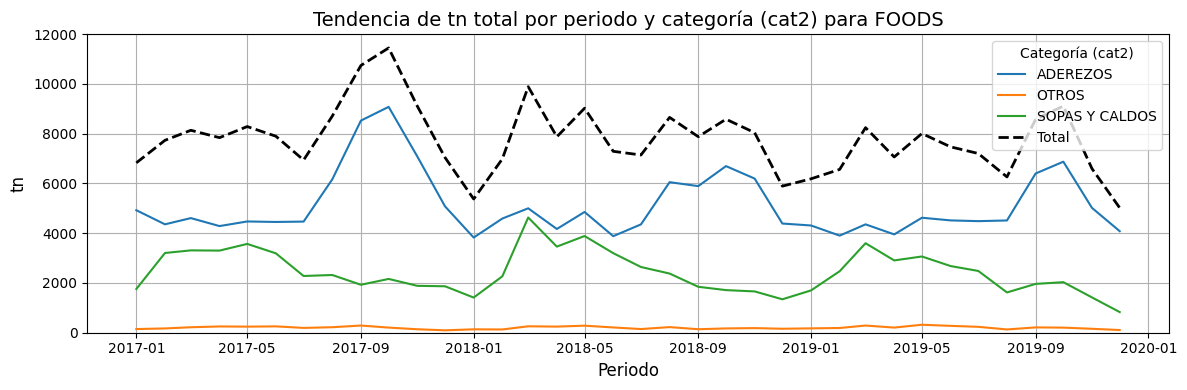

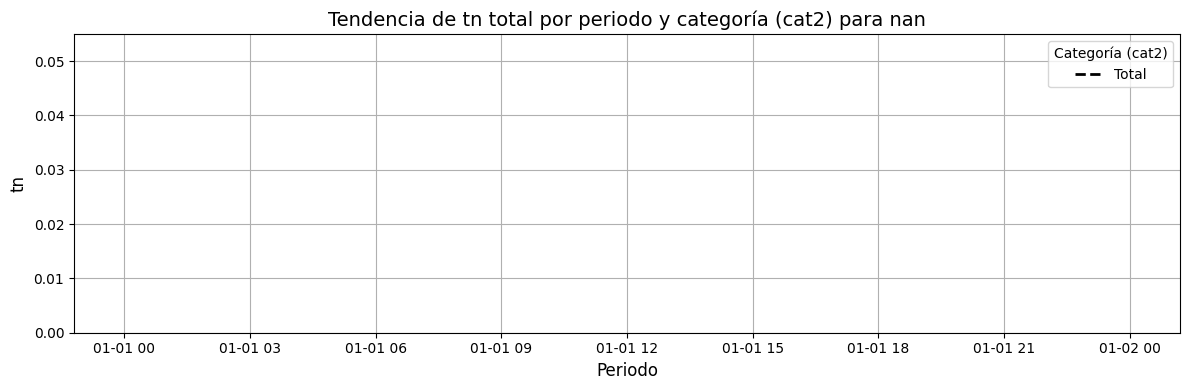

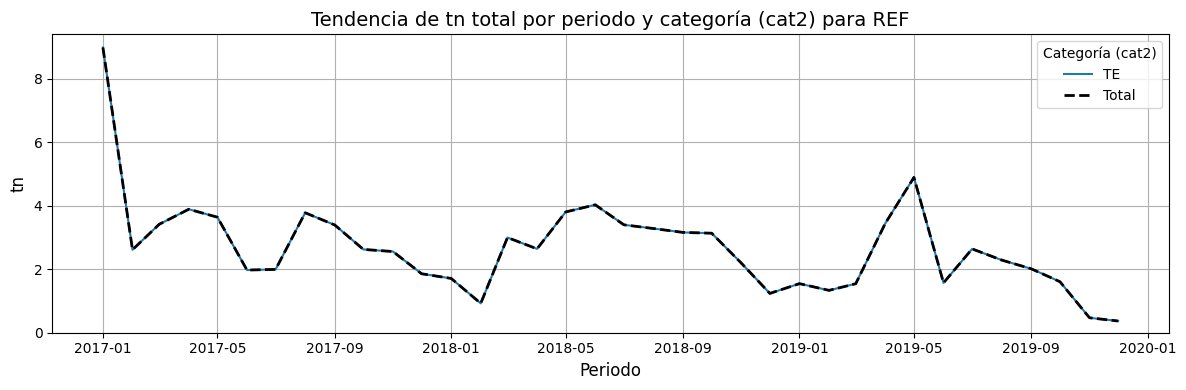

In [13]:
# Iterar sobre cada categoría en cat1
for cat1 in df['cat1'].unique():
    # Filtrar los datos para la categoría actual de cat1
    period_cat2_tn = df[df['cat1'] == cat1].groupby(['periodo', 'cat2'])['tn'].sum().reset_index()
    
    # Calcular el total de tn por periodo para la categoría actual de cat1
    period_total_tn = df[df['cat1'] == cat1].groupby('periodo')['tn'].sum().reset_index()
    
    # Crear el gráfico
    plt.figure(figsize=(12, 4))
    
    # Graficar una línea para cada categoría en cat2
    for cat2 in period_cat2_tn['cat2'].unique():
        data = period_cat2_tn[period_cat2_tn['cat2'] == cat2]
        plt.plot(data['periodo'], data['tn'], label=cat2)
    
    # Graficar la línea del total
    plt.plot(period_total_tn['periodo'], period_total_tn['tn'], label='Total', color='black', linewidth=2, linestyle='--')
    
    # Configurar etiquetas y título
    plt.title(f'Tendencia de tn total por periodo y categoría (cat2) para {cat1}', fontsize=14)
    plt.ylabel('tn', fontsize=12)
    plt.xlabel('Periodo', fontsize=12)
    plt.ylim(bottom=0)
    plt.legend(title='Categoría (cat2)')
    plt.grid(True)
    plt.tight_layout()
    
    # Mostrar el gráfico
    plt.show()

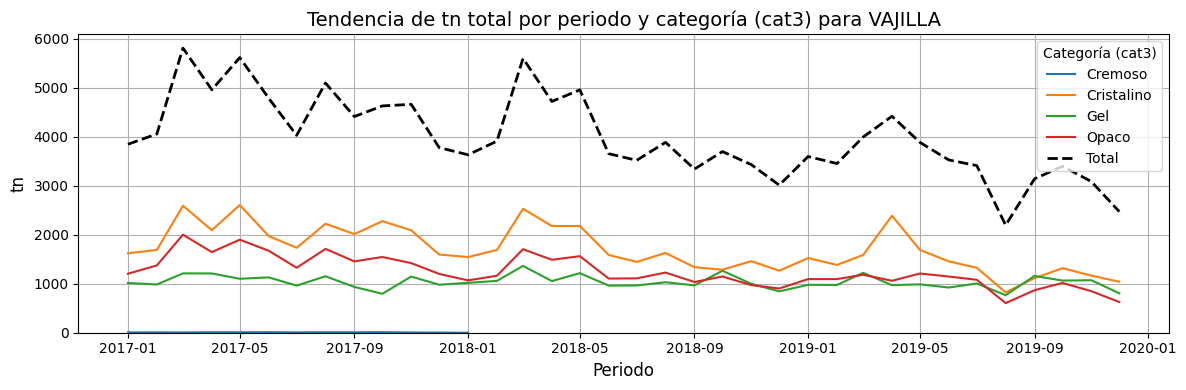

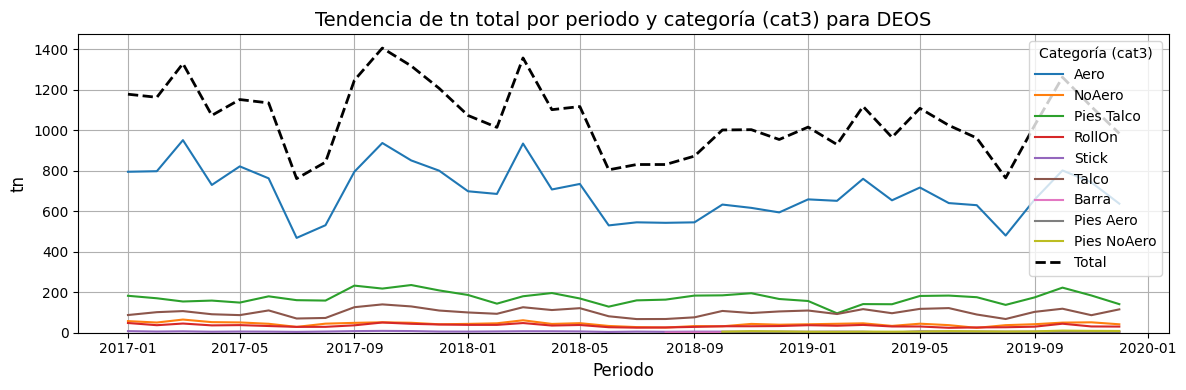

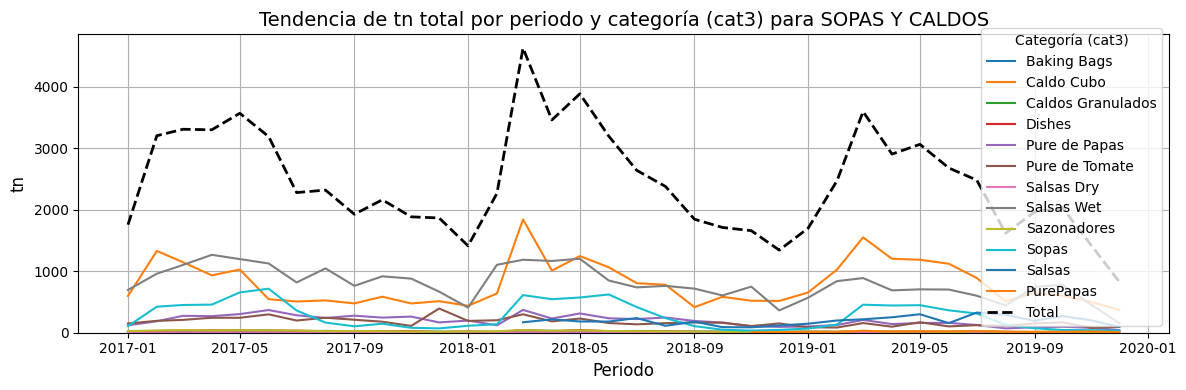

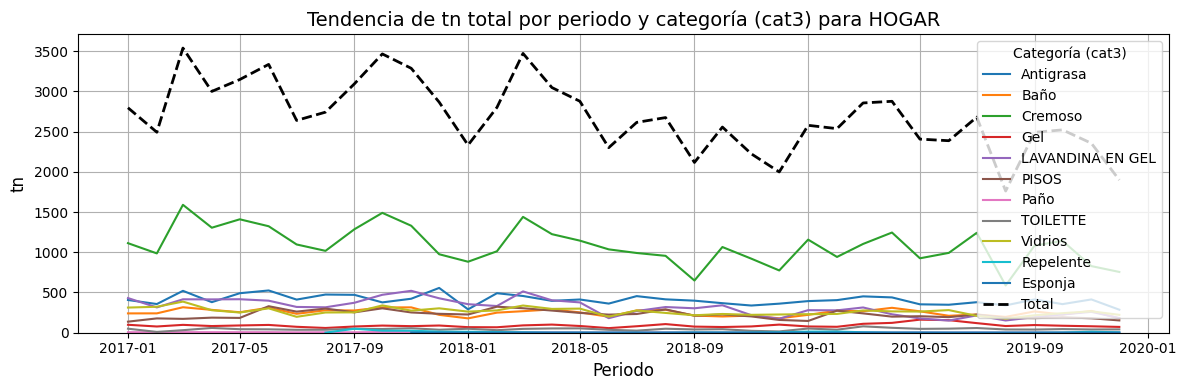

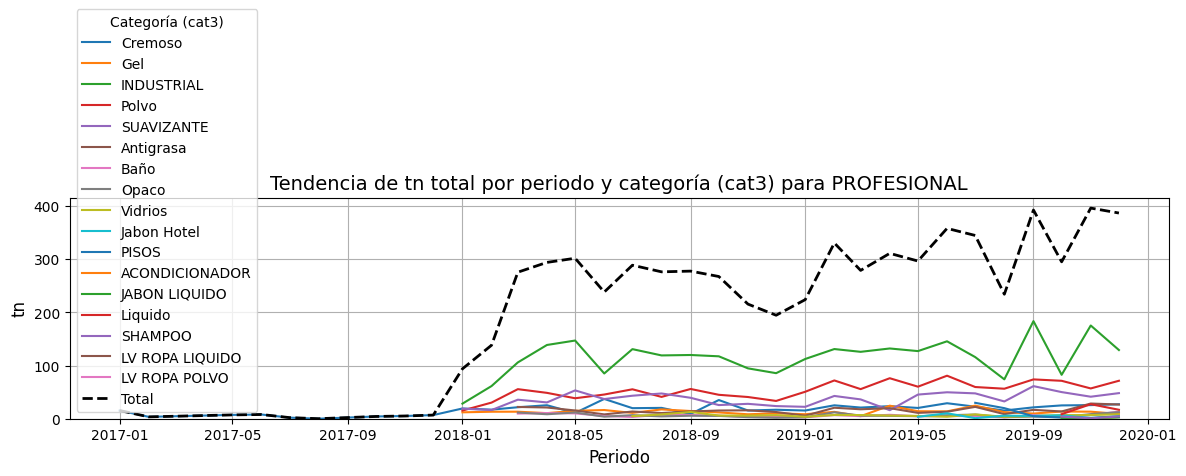

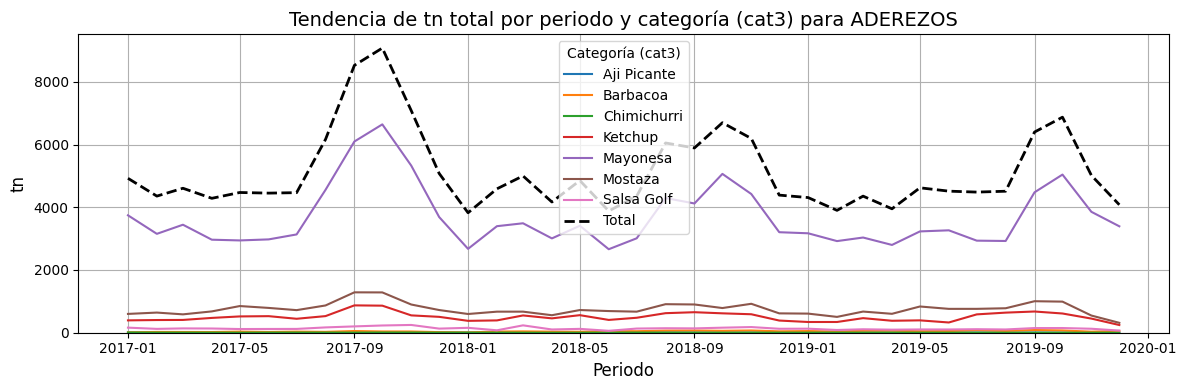

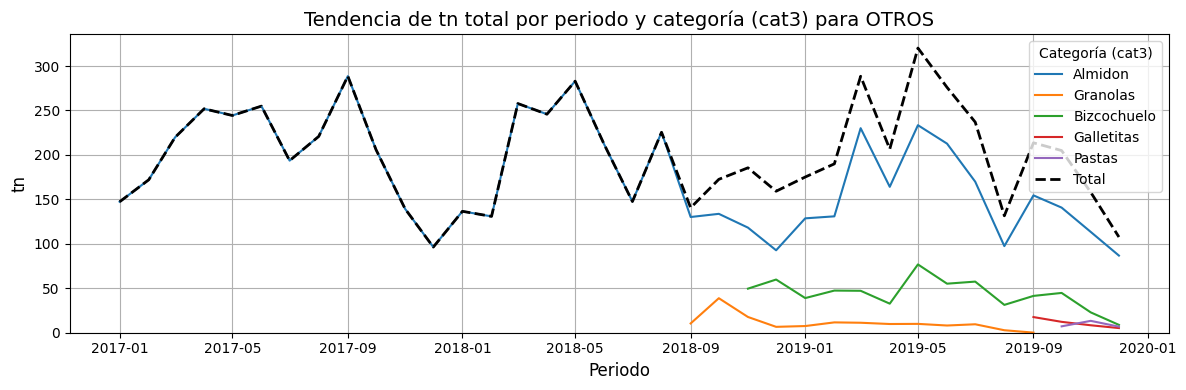

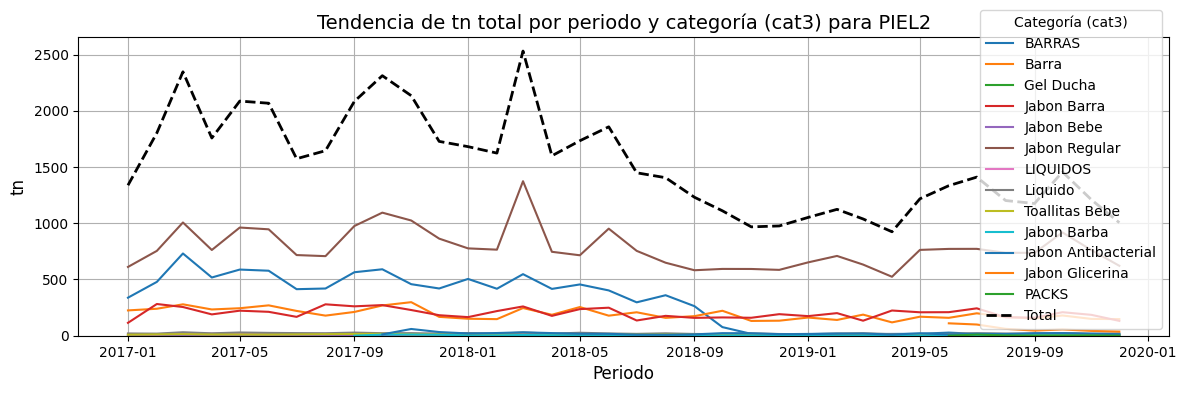

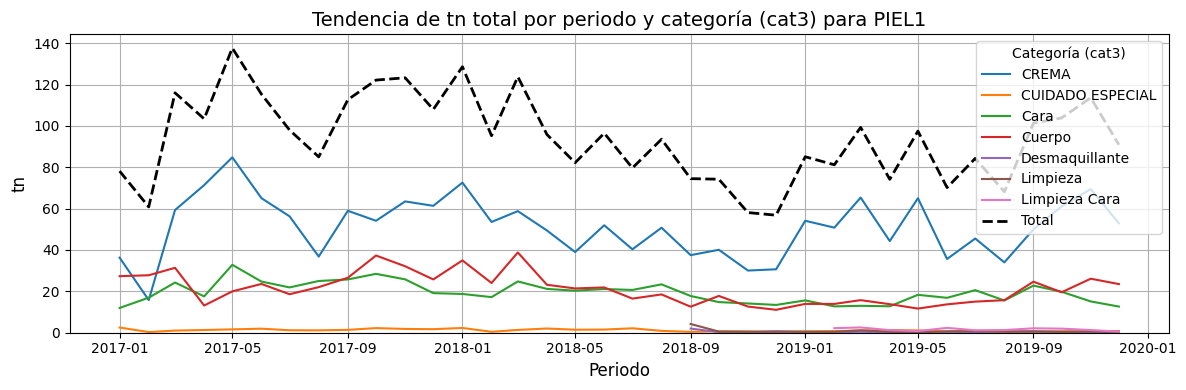

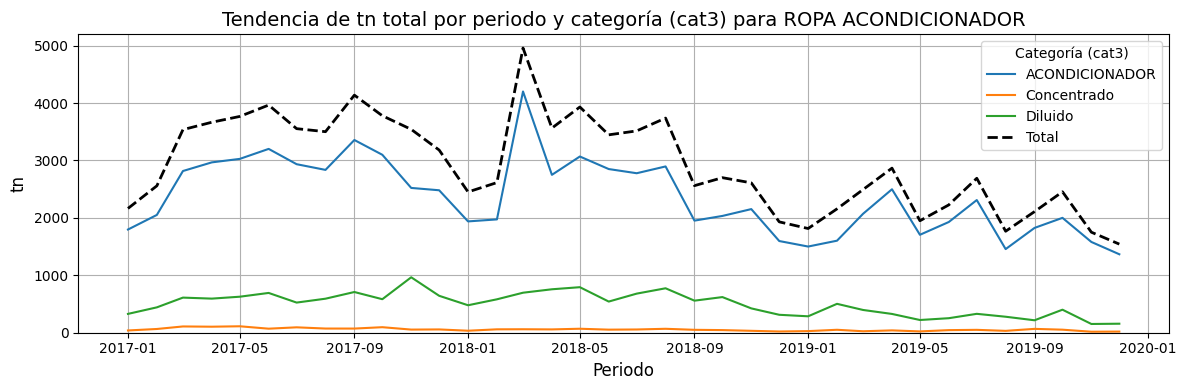

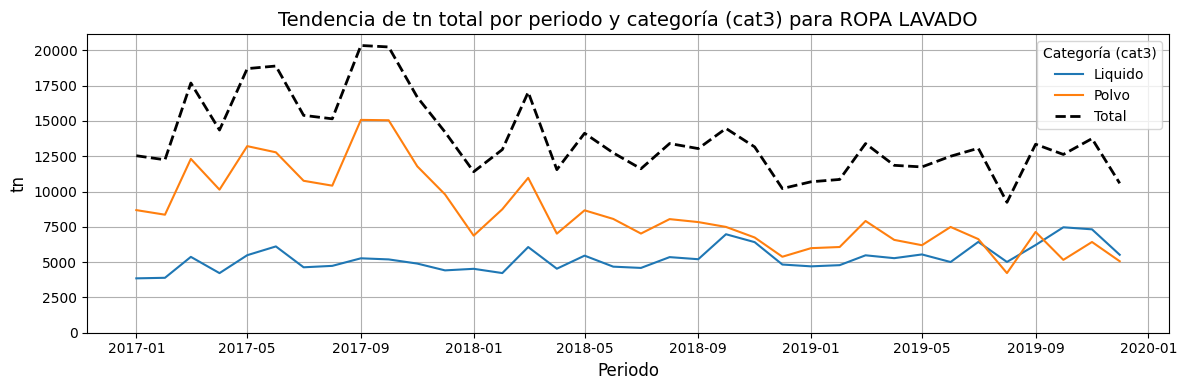

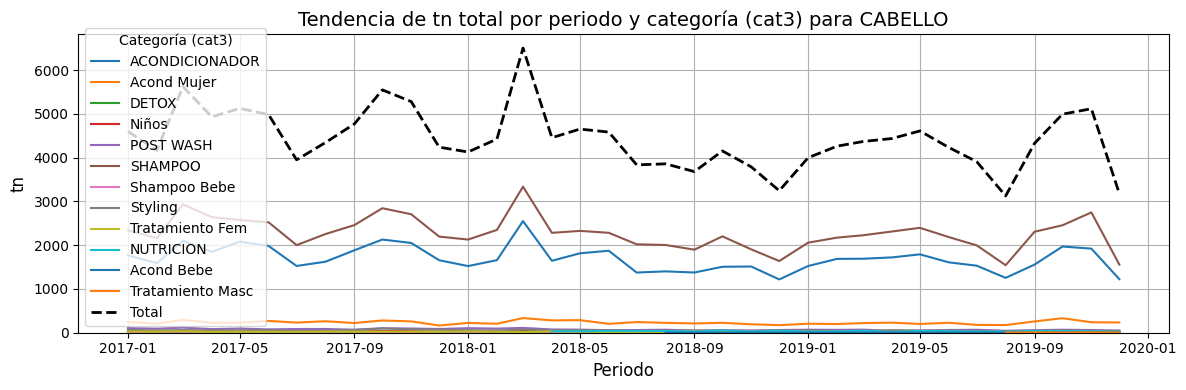

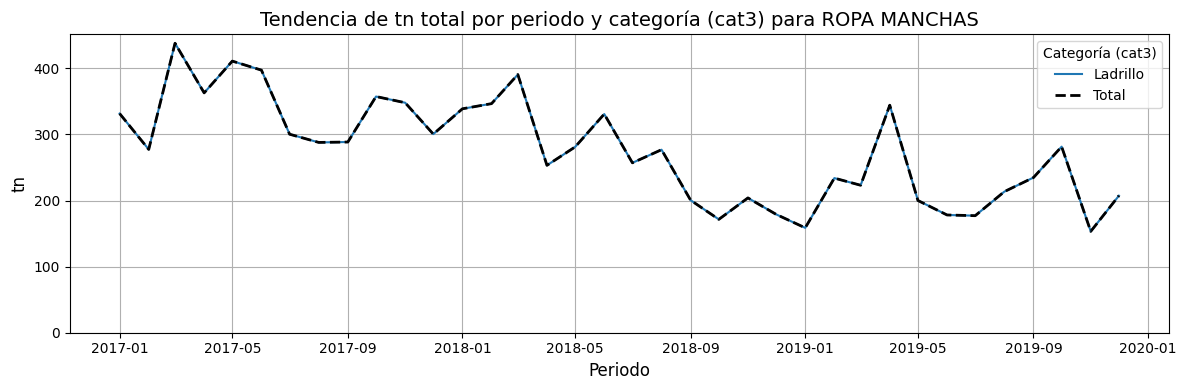

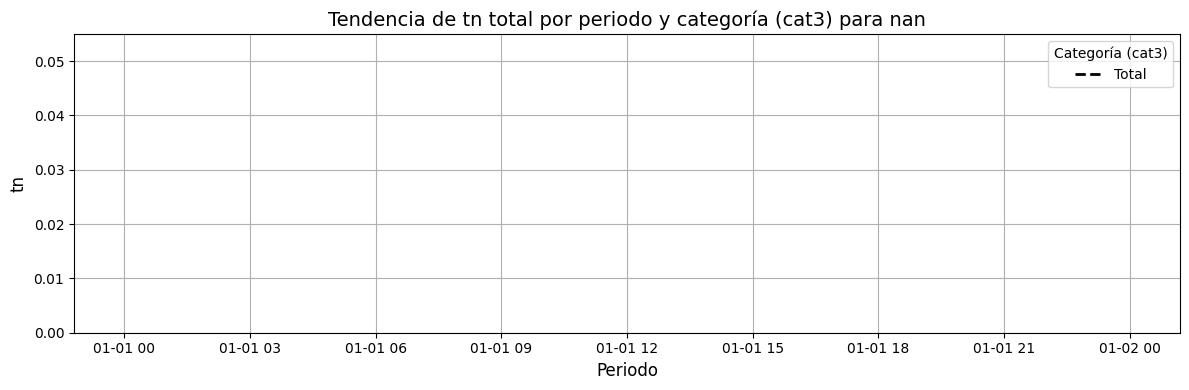

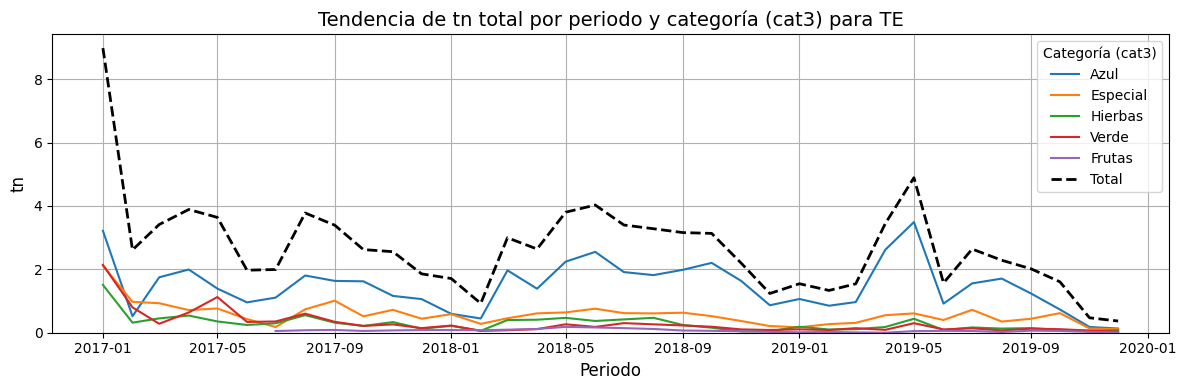

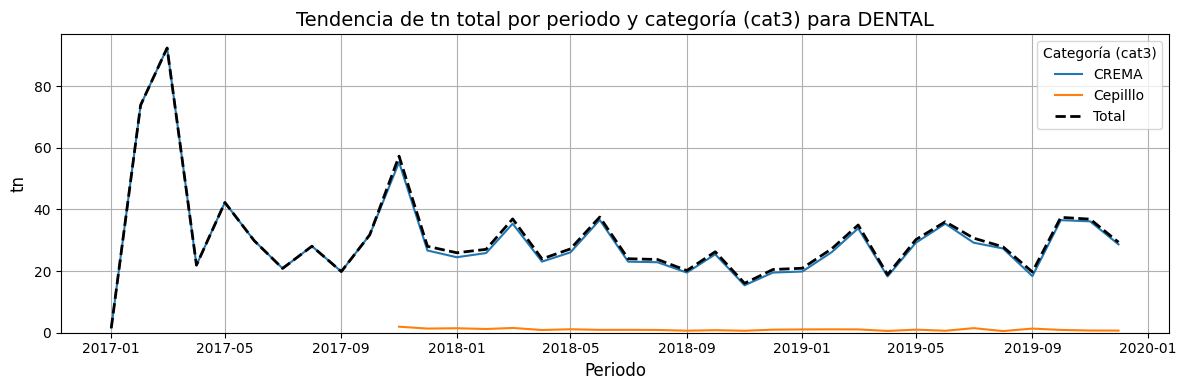

In [38]:
# Iterar sobre cada categoría en cat2
for cat2 in df['cat2'].unique():
    # Filtrar los datos para la categoría actual de cat2
    period_cat3_tn = df[df['cat2'] == cat2].groupby(['periodo', 'cat3'])['tn'].sum().reset_index()
    
    # Calcular el total de tn por periodo para la categoría actual de cat2
    period_total_tn = df[df['cat2'] == cat2].groupby('periodo')['tn'].sum().reset_index()
    
    # Crear el gráfico
    plt.figure(figsize=(12, 4))
    
    # Graficar una línea para cada categoría en cat3
    for cat3 in period_cat3_tn['cat3'].unique():
        data = period_cat3_tn[period_cat3_tn['cat3'] == cat3]
        plt.plot(data['periodo'], data['tn'], label=cat3)
    
    # Graficar la línea del total
    plt.plot(period_total_tn['periodo'], period_total_tn['tn'], label='Total', color='black', linewidth=2, linestyle='--')
    
    # Configurar etiquetas y título
    plt.title(f'Tendencia de tn total por periodo y categoría (cat3) para {cat2}', fontsize=14)
    plt.ylabel('tn', fontsize=12)
    plt.xlabel('Periodo', fontsize=12)
    plt.ylim(bottom=0)
    plt.legend(title='Categoría (cat3)')
    plt.grid(True)
    plt.tight_layout()
    
    # Mostrar el gráfico
    plt.show()

In [62]:
def grafico_categoria_sum_byTn(categoria):
    plt.figure(figsize=(12, 6))
    for cat in df[categoria].unique():
        cat_data = df[df[categoria] == cat].groupby('periodo')['tn'].sum().reset_index() 
        plt.plot(cat_data['periodo'], cat_data['tn'], label=categoria)

    # Personalizar el gráfico
    plt.title(f'Evolución de Tn por {categoria}')
    plt.ylabel('Toneladas')
    plt.legend(title=categoria)
    plt.grid(True)
    plt.tight_layout()


    # Mostrar el gráfico
    plt.show()

In [ ]:
grafico_categoria_sum_byTn('product_id')

### ANALISIS POR CLIENTES

In [15]:
# 7. Top 10 clientes por tn acumulado
top_clients = df.groupby('customer_id')['tn'].sum().reset_index().sort_values('tn', ascending=False).head(10)


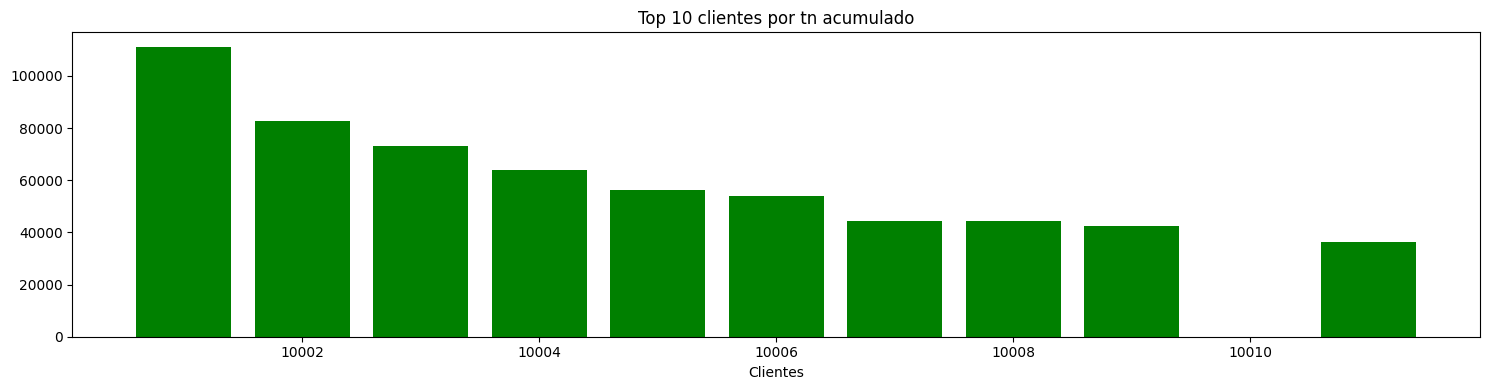

In [20]:

customers=top_clients['customer_id'].to_numpy()

plt.figure(figsize=(15, 4))
plt.bar(customers,top_clients['tn'],color='green')
plt.title('Top 10 clientes por tn acumulado')
plt.xlabel('Clientes')
plt.tight_layout()
plt.show()

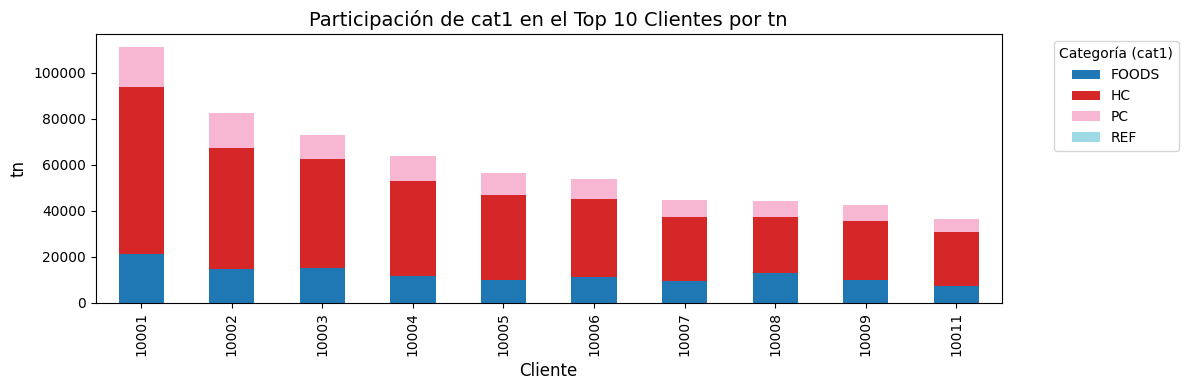

In [22]:
# Filtrar los datos para los clientes en el top 10
top_clients_ids = top_clients['customer_id']
df_top_clients = df[df['customer_id'].isin(top_clients_ids)]

# Agrupar por cliente y cat1, y calcular la suma de tn
stacked_data = df_top_clients.groupby(['customer_id', 'cat1'])['tn'].sum().unstack(fill_value=0)

# Crear el gráfico de barras apiladas
stacked_data.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 4),
    colormap='tab20'
)

# Configurar etiquetas y título
plt.title('Participación de cat1 en el Top 10 Clientes por tn', fontsize=14)
plt.xlabel('Cliente', fontsize=12)
plt.ylabel('tn', fontsize=12)
plt.legend(title='Categoría (cat1)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

/tmp/ipykernel_5185/861679604.py:16: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


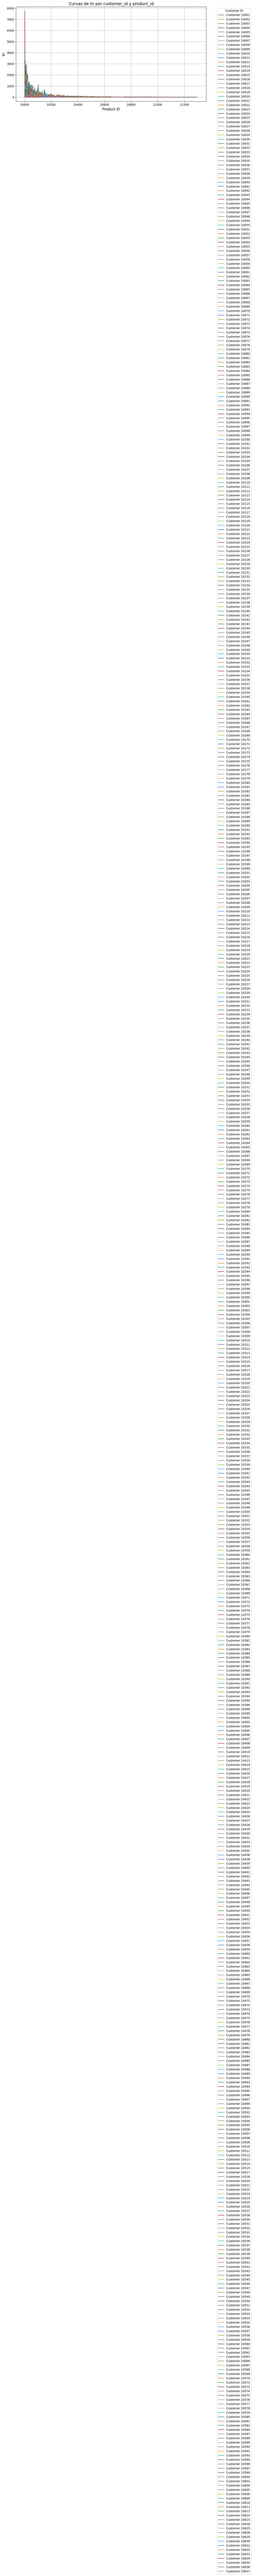

In [40]:
# Agrupar por customer_id y product_id, y calcular la suma de tn
customer_product_tn = df.groupby(['customer_id', 'product_id'])['tn'].sum().reset_index()

# Iterar sobre cada customer_id y graficar su curva
plt.figure(figsize=(12, 6))
for customer in customer_product_tn['customer_id'].unique():
    data = customer_product_tn[customer_product_tn['customer_id'] == customer]
    plt.plot(data['product_id'], data['tn'], label=f'Customer {customer}')

# Configurar etiquetas y título
plt.title('Curvas de tn por customer_id y product_id', fontsize=14)
plt.xlabel('Product ID', fontsize=12)
plt.ylabel('tn', fontsize=12)
plt.legend(title='Customer ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [ ]:
# Parámetros de filtro
customers = ['1001', '1002','1003']  # Lista de customer_id a incluir
products = ['1', '2']  # Lista de product_id a incluir

# Filtrar el DataFrame por los parámetros especificados
filtered_data = df[
    (df['customer_id'].astype(str).isin(customers)) & 
    (df['product_id'].astype(str).isin(products))
]

# Agrupar por customer_id y product_id, y calcular la suma de tn
customer_product_tn = filtered_data.groupby(['customer_id', 'product_id'])['tn'].sum().reset_index()

# Iterar sobre cada customer_id y graficar su curva
plt.figure(figsize=(12, 6))
for customer in customer_product_tn['customer_id'].unique():
    data = customer_product_tn[customer_product_tn['customer_id'] == customer]
    plt.plot(data['product_id'], data['tn'], label=f'Customer {customer}')

# Configurar etiquetas y título
plt.title('Curvas de tn por customer_id y product_id (Filtrado)', fontsize=14)
plt.xlabel('Product ID', fontsize=12)
plt.ylabel('tn', fontsize=12)
plt.legend(title='Customer ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

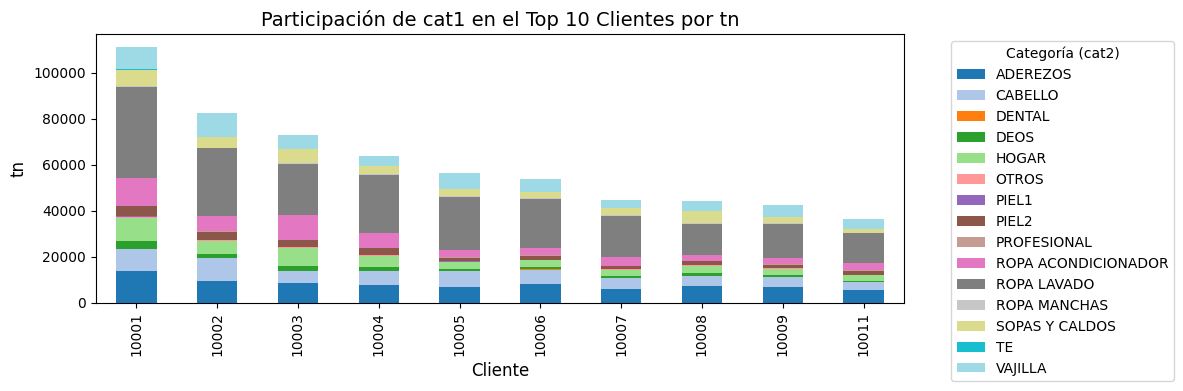

In [39]:
# Filtrar los datos para los clientes en el top 10
top_clients_ids = top_clients['customer_id']
df_top_clients = df[df['customer_id'].isin(top_clients_ids)]

# Agrupar por cliente y cat1, y calcular la suma de tn
stacked_data = df_top_clients.groupby(['customer_id', 'cat2'])['tn'].sum().unstack(fill_value=0)

# Crear el gráfico de barras apiladas
stacked_data.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 4),
    colormap='tab20'
)

# Configurar etiquetas y título
plt.title('Participación de cat1 en el Top 10 Clientes por tn', fontsize=14)
plt.xlabel('Cliente', fontsize=12)
plt.ylabel('tn', fontsize=12)
plt.legend(title='Categoría (cat2)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

### ANALISIS POR PRODUCTOS

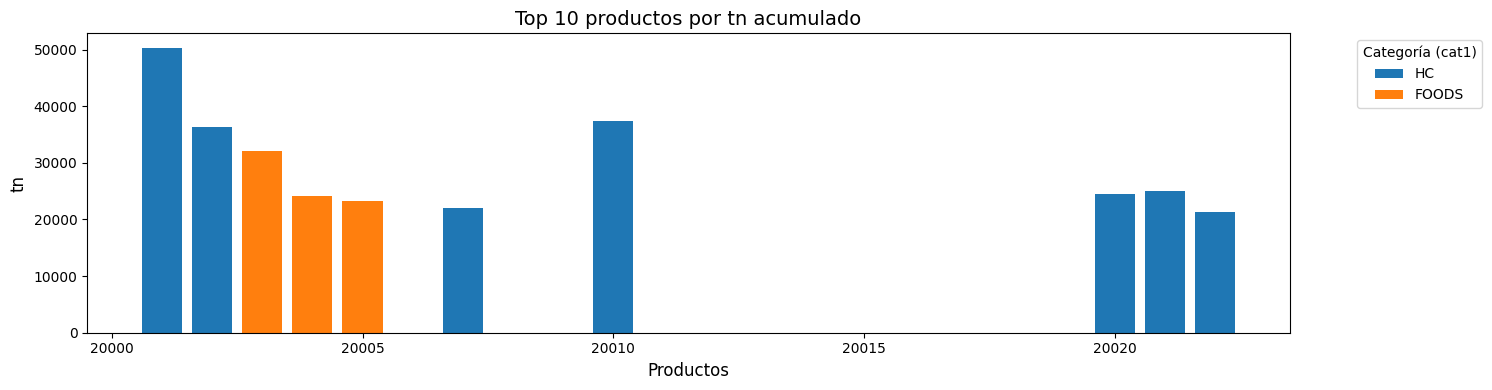

In [25]:
# Obtener los datos del top 10 productos con su categoría cat1
top_products = df.groupby(['product_id', 'cat1'])['tn'].sum().reset_index()
top_products = top_products.sort_values('tn', ascending=False).head(10)

# Crear un mapeo de colores para cada categoría de cat1
unique_cat1 = top_products['cat1'].unique()
color_map = {cat: color for cat, color in zip(unique_cat1, plt.cm.tab10.colors)}

# Crear el gráfico de barras con colores por cat1
plt.figure(figsize=(15, 4))
for i, row in top_products.iterrows():
    plt.bar(row['product_id'], row['tn'], color=color_map[row['cat1']], label=row['cat1'] if row['cat1'] not in plt.gca().get_legend_handles_labels()[1] else "")

# Configurar etiquetas y título
plt.title('Top 10 productos por tn acumulado', fontsize=14)
plt.xlabel('Productos', fontsize=12)
plt.ylabel('tn', fontsize=12)
plt.legend(title='Categoría (cat1)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Mostrar el gráfico
plt.show()

### ANALISIS POR MARCAS

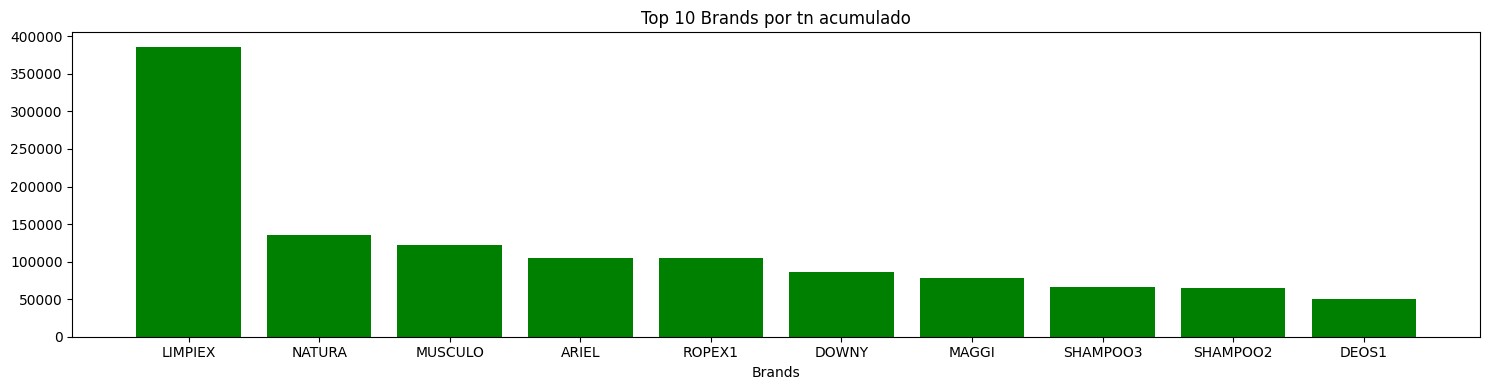

In [30]:

top_brands = df.groupby('brand')['tn'].sum().reset_index().sort_values('tn', ascending=False).head(10)
brands=top_brands['brand'].to_numpy()

plt.figure(figsize=(15, 4))
plt.bar(brands,top_brands['tn'],color='green')
plt.title('Top 10 Brands por tn acumulado')
plt.xlabel('Brands')
plt.tight_layout()
plt.show()

# Merge entre productos a predecir y sell-in

In [14]:
# merge con productos_predecir con el sell_in
df_predecir = pd.merge(prod_predecir,sell_in, on='product_id', how='left')
print(df_predecir.head(20))
# cantidad de combinaciones prod_predecir y customer_id
combinaciones = df_predecir.groupby(['product_id', 'customer_id']).size().reset_index(name='count')
print(combinaciones['count']>0)
# Agrupar por product_id y customer_id, y calcular la suma de tn

    product_id  periodo  customer_id  plan_precios_cuidados  cust_request_qty  \
0        20001   201701        10001                      0                11   
1        20001   201701        10063                      0                 1   
2        20001   201701        10080                      0                 1   
3        20001   201701        10094                      0                 1   
4        20001   201701        10184                      0                 1   
5        20001   201701        10149                      0                 1   
6        20001   201701        10171                      0                 1   
7        20001   201701        10208                      0                 1   
8        20001   201701        10007                      0                 3   
9        20001   201701        10279                      0                 1   
10       20001   201701        10099                      0                 2   
11       20001   201701     

In [ ]:
print(len(df_predecir['product_id'].unique()))
print(len(sell_in['product_id'].unique()))
print(len(sell_in['customer_id'].unique()))


780
1233
597
